In [313]:
%matplotlib inline
import os
import glob

import seaborn as sns
sns.set_style('white')

from pprint import pprint
import numpy as np
import pandas as pd
from planet import api
import matplotlib.pyplot as plt
from pysurvey.plot import setup_sns as setup
plt.rc('axes.formatter', useoffset=False)


In [109]:
import gdal
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i+n]
# for i, chunk in enumerate(chunks(points, 600)):
#     print i, len(chunk)

In [147]:
from osgeo import gdal
from pyproj import Proj, transform

# filename = "/Users/ajmendez/tmp/world/planet/open_california_re_20150601_20150831/L15-0317E-1285N.tif" 
# filename = "/Users/ajmendez/tmp/world/planet/open_california_re_20150601_20150831/L15-0337E-1233N.tif" 
# filename = "/Users/ajmendez/tmp/world/planet/open_california_re_20150601_20150831/" 
filename = "/Users/ajmendez/tmp/world/planet/20160227_224704_0b07_visual.tif" 
ds = gdal.Open(filename)
print ds.GetMetadata()
ds.GetRasterBand(1)

width = ds.RasterXSize
height = ds.RasterYSize
gt = ds.GetGeoTransform()
minx = gt[0]
miny = gt[3] + width*gt[4] + height*gt[5] 
maxx = gt[0] + width*gt[1] + height*gt[2]
maxy = gt[3] 


print minx, maxx, miny, maxy

{'AREA_OR_POINT': 'Area'}
546645.0 557778.0 4120218.0 4132110.0


In [157]:
# !pip install rasterio
import rasterio
from affine import Affine


In [341]:
inproj = Proj(init='EPSG:32610')
outproj = Proj(init='epsg:4326')

def pixel2coord(ds, col, row):
    """Returns global coordinates to pixel center using base-0 raster index"""
    c, a, b, f, d, e = ds.GetGeoTransform()
    xp = a * col + b * row + a * 0.5 + b * 0.5 + c
    yp = d * col + e * row + d * 0.5 + e * 0.5 + f
#     return(xp, yp)
    return transform(inproj,outproj,xp,yp)

# with rasterio.open(filename) as r:
#     T0 = r.affine  # upper-left paixel corner affine transform
#     p1 = Proj(r.crs)
#     A = r.read_band(1)
# cols, rows = np.meshgrid(np.arange(A.shape[1]), np.arange(A.shape[0]))

# # Get affine transform for pixel centres
# T1 = T0 * Affine.translation(0.5, 0.5)
# # Function to convert pixel row/column index (from 0) to easting/northing at centre
# rc2en = lambda r, c: (c, r) * T1

# # All eastings and northings (there is probably a faster way to do this)
# eastings, northings = np.vectorize(rc2en, otypes=[np.float, np.float])(rows, cols)
# # longs, lats = transform(p1, p1.to_latlong(), eastings, northings)


In [342]:
pixel2coord(ds, 0,0)

(-122.42116003423078, 37.35824968812776)

In [93]:
!gdalinfo $filename

Driver: GTiff/GeoTIFF
Files: /Users/ajmendez/tmp/world/planet/20160227_224704_0b07_visual.tif
Size is 3711, 3964
Coordinate System is:
PROJCS["WGS 84 / UTM zone 10N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-123],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AUTHORITY["EPSG","32610"]]
Origin = (546645.000000000000000,4132110.000000000000000)
Pixel Size = (3.000000000000000,-3.000000000000000)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  COMPRESSION=LZW
  INTERLEAVE=BAND
Corner Coordinates:
Upp

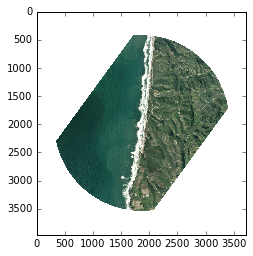

In [94]:
rgb = [ds.GetRasterBand(i+1) for i in range(4)]
arr = [band.ReadAsArray() for band in rgb]
rgb = np.dstack(arr)
plt.imshow(rgb[:,:,:])

In [95]:
import cv2

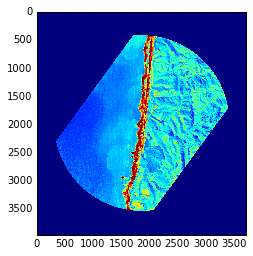

In [96]:
im = cv2.imread(filename)
imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
plt.imshow(imgray)

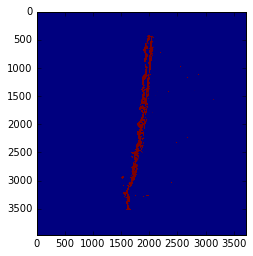

In [115]:
ret,thresh = cv2.threshold(imgray,200,255,0)
plt.imshow(thresh)


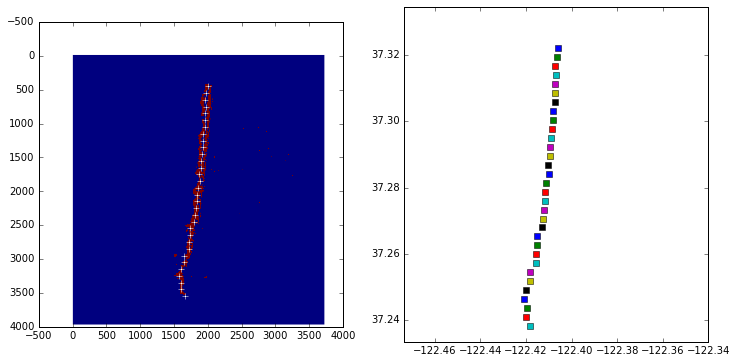

In [190]:


fig, (ax,ax2) = plt.subplots(figsize=(12,6), nrows=1, ncols=2)
ax2.xaxis.get_major_formatter().useOffset = False
ax2.yaxis.get_major_formatter().useOffset = False
lower = pixel2coord(ds, 0,0)
upper = pixel2coord(ds, *rgb.shape[:2])
ax2.set_xlim(lower[0], upper[0])
ax2.set_ylim(upper[1], lower[1])

ax.imshow(thresh)
      
for i, index in enumerate(chunks(range(thresh.shape[0]), 100)):
    tmp = thresh[index,:]
    if max(tmp.flatten()) > 0:
        x = zip(*np.argwhere(tmp.mean(axis=0) > 64))[0]
        ax.plot(np.mean(x), np.mean(index), '+w', zorder=100)
        lon,lat = pixel2coord(ds, np.mean(x), np.mean(index))
        ax2.plot(lon, lat, 's')
        
#         plt.plot(np.mean(index), np.mean(np.where(tmp > 0)))
#     print(thresh[index, :].max(axis=1))


# Generalize

In [197]:
def load_images(filename):
    ds = gdal.Open(filename)
    rgb = [ds.GetRasterBand(i+1) for i in range(4)]
    arr = [band.ReadAsArray() for band in rgb]
    rgb = np.dstack(arr)
    
    im = cv2.imread(filename)
    imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    
    return (ds, rgb, imgray)
    
    
filenames = glob.glob("/Users/ajmendez/tmp/world/planet_order_19140/*/*.tif")
images = []
for filename in filenames:
    images.append(load_images(filename))


In [204]:
len(images)

10

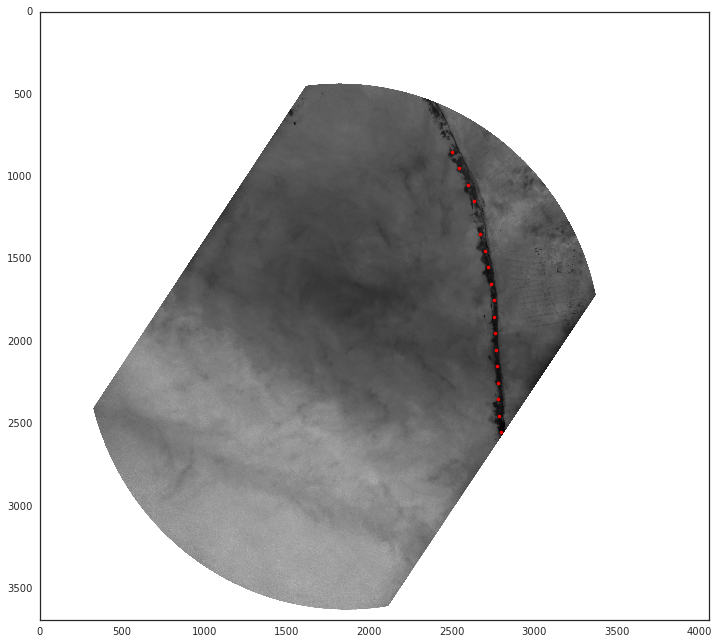

In [327]:
def process_image(ds, imgray, tcut=64, threshold=None, ax=None):
    out = []
    if threshold is None:
        threshold = int(np.percentile(imgray[imgray>0], 99.2))
    if ax is None:
        ax = plt.gca()
    
    ret,thresh = cv2.threshold(imgray,threshold,255,0)
#     ax.imshow(thresh, zorder=-2)
    
    for i, index in enumerate(chunks(range(thresh.shape[0]), 100)):
        tmp = thresh[index,:]
        if max(tmp.flatten()) > 0:
            pts = np.argwhere(tmp.mean(axis=0) > tcut)
            if len(pts) == 0:
                continue
            x = zip(*pts)[0]
            ax.plot([np.mean(x)], [np.mean(index)], '.r', zorder=10)
            lon,lat = pixel2coord(ds, np.mean(x), np.mean(index))
            out.append([lon,lat])
    return out

plt.figure(figsize=(12,12))
plt.xlim(0, imgray.shape[0])
plt.ylim(imgray.shape[1],0)
plt.imshow(imgray, zorder=-2)
process_image(ds, imgray)
None

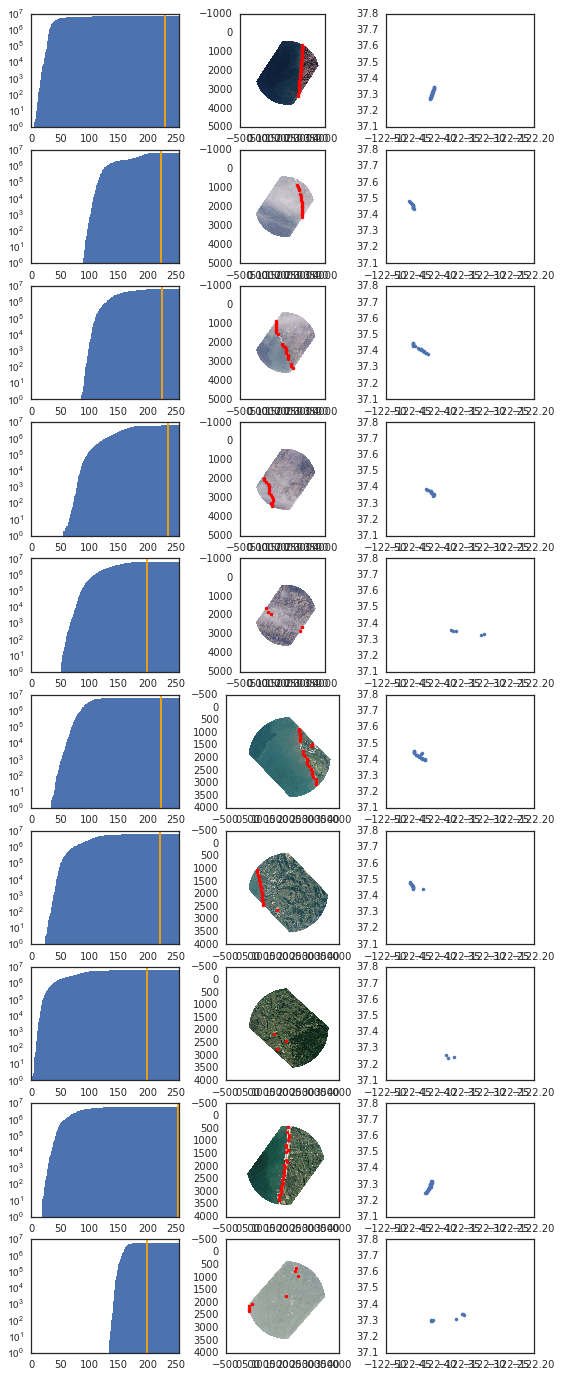

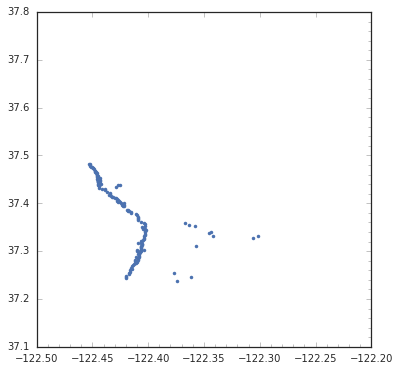

In [339]:
# All of California
xr = [-125, -114]
yr = [32, 42.2]

# Bayish area
xr = [-122.5, -122.2]
yr = [37.1, 37.8]

points = []
fig, axes = plt.subplots(10,3, figsize=(9,24))
for i,((ds,rgb,imgray), (ax1,ax2,ax3)) in enumerate(zip(images, axes)):
    
    ax1.hist(imgray[imgray>0], np.linspace(0,255,256), lw=0, cumulative=True)
    xcut = max([200, np.percentile(imgray[imgray>0], 99.2)])
    ax1.axvline(xcut, color='orange')
    ax1.set(xlim=[0,255], yscale='log')

    ax2.imshow(rgb)
    tmp = process_image(ds, imgray, threshold=xcut, ax=ax2)
    points.extend(tmp)
    
    x,y = zip(*tmp)
    ax3.plot(x,y, '.')
    ax3.set(xlim=xr,
            ylim=yr)
#     if i > 0:
#         break

ax = setup(figsize=(6,6), xr=xr,yr=yr)
x,y = zip(*points)
plt.plot(x,y, '.')

In [ ]:
max()